In [2]:
print("Step 1: Installing project dependencies...")
# We use a quiet installation to keep the output clean
!pip install -q "numpy<2.0"
!pip install -q requests  # Add requests for image downloading
!pip install -q datasets==2.15.0 pyarrow==14.0.1
!pip install -q transformers bitsandbytes accelerate pillow pandas matplotlib
print("✅ Dependencies installed.")

Step 1: Installing project dependencies...
✅ Dependencies installed.


In [3]:
print("Downloading VSR dataset...")
!wget -q https://raw.githubusercontent.com/cambridgeltl/visual-spatial-reasoning/master/data/splits/random/test.jsonl
!wget -q https://raw.githubusercontent.com/cambridgeltl/visual-spatial-reasoning/master/data/splits/random/train.jsonl
!wget -q https://raw.githubusercontent.com/cambridgeltl/visual-spatial-reasoning/master/data/splits/random/dev.jsonl
print("✅ Dataset files downloaded")

✅ Dataset files downloaded


In [4]:
print("Cleaning duplicate files...")
!rm -f *.jsonl.*  # Remove all backup files
print("Current directory contents:")
!ls -lh

Cleaning duplicate files...
Current directory contents:
total 3.3M
-rw-r--r-- 1 root root 331K Jun 19 14:32 dev.jsonl
-rw-r--r-- 1 root root 659K Jun 19 14:32 test.jsonl
-rw-r--r-- 1 root root 2.3M Jun 19 14:32 train.jsonl


In [6]:
import json
import os
import sys
import requests
import logging
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration, BitsAndBytesConfig
from PIL import Image
import matplotlib.pyplot as plt

# Configure logging
logging.basicConfig(
    level=logging.DEBUG,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler(sys.stdout)]
)
logger = logging.getLogger(__name__)

print("✅ Essential libraries imported")

✅ Essential libraries imported


In [7]:
PROJECT_PATH = '/kaggle/input/mats-src'  
sys.path.append(PROJECT_PATH)
print(f"Project path set to: {PROJECT_PATH}")

Project path set to: /kaggle/input/mats-src


In [8]:
try:
    from src.mats import auditor
    print("✅ Custom auditor module loaded successfully.")
except ImportError as e:
    print(f"❌ Failed to import auditor module. Error: {e}")
    print("--> Please ensure your zipped 'src' folder was added as a dataset")

✅ Custom auditor module loaded successfully.


In [9]:
print("\n=== File Verification ===")
for split in ['test', 'train', 'dev']:
    path = f"{split}.jsonl"
    exists = os.path.exists(path)
    size = os.path.getsize(path) if exists else 0
    status = "✅" if exists else "❌"
    print(f"{path}: {status} {size/1024:.1f} KB")


=== File Verification ===
test.jsonl: ✅ 658.9 KB
train.jsonl: ✅ 2306.8 KB
dev.jsonl: ✅ 330.1 KB


In [10]:
print("\nLoading LLaVA model (this may take a few minutes)...")
model_id = "llava-hf/llava-1.5-7b-hf"

quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16
)

processor = AutoProcessor.from_pretrained(model_id)
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    quantization_config=quantization_config,
    device_map="auto"
)

print("✅ Model loaded successfully!")


Loading LLaVA model (this may take a few minutes)...


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.45k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.62M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/70.1k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

✅ Model loaded successfully!



Loading dataset via auditor module...
Loaded 100 VSR samples.

--- Sample Item from Loaded Dataset ---
Caption: The bird is above the cat.
Relation Type: above


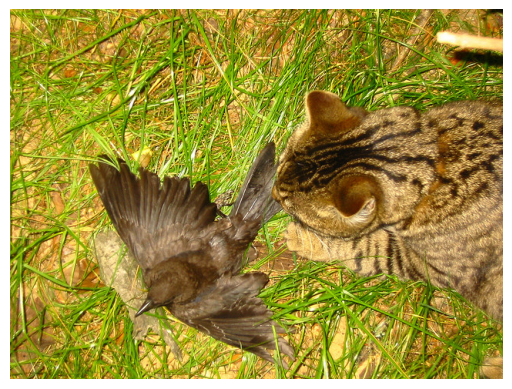

In [11]:
print("\nLoading dataset via auditor module...")
vsr_data = auditor.load_vsr_dataset(split='test', num_samples=100)
print(f"Loaded {len(vsr_data)} VSR samples.")

if vsr_data:
    print("\n--- Sample Item from Loaded Dataset ---")
    sample_item = vsr_data[0]
    print(f"Caption: {sample_item['caption']}")
    print(f"Relation Type: {sample_item.get('relation_type', 'unknown')}")
    
    # Display the image
    plt.imshow(sample_item['image'])
    plt.axis('off')
    plt.show()
else:
    print("\n⚠️ Could not load real data. Please check logs.")

In [6]:
print("\n=== Testing First 3 Samples ===")
for split in ['test']:  # Only test split for brevity
    path = f"{split}.jsonl"
    print(f"\nTesting {path}:")
    try:
        with open(path, "r") as f:
            for i, line in enumerate(f):
                if i >= 3: break
                data = json.loads(line)
                print(f"Sample {i+1}:")
                print(f"  Caption: {data['caption'][:70]}...")
                print(f"  Relation: {data['relation']}")
                print(f"  Label: {data['label']}")
                print(f"  Image: {data['image'][:50]}...")
    except Exception as e:
        print(f"Error: {str(e)}")


=== Testing First 3 Samples ===

Testing test.jsonl:
Error: [Errno 2] No such file or directory: 'test.jsonl'
